In [1]:
import numpy as np
import matplotlib as plt
from matplotlib import pyplot
from pandas import read_csv
import math
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from google.colab import drive
from sklearn.preprocessing import MinMaxScaler

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
!cd '/content/gdrive/My Drive/'


Mounted at /content/gdrive


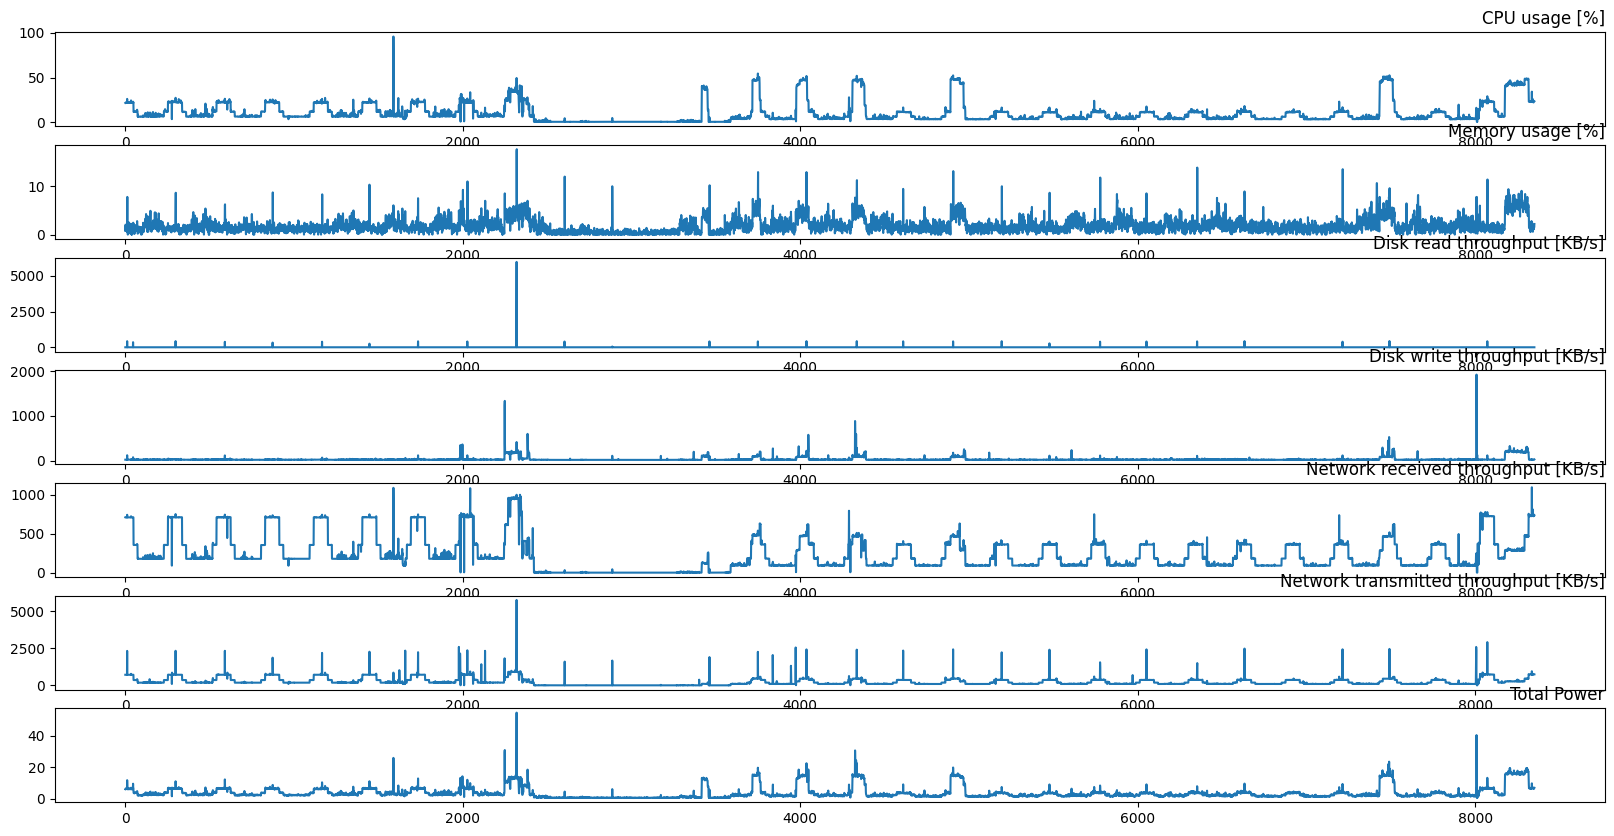

In [3]:
data = read_csv('gdrive/My Drive/archive/power_other.csv',header=0, index_col=0, engine='python')
values = data.values
groups = [0,1,2,3,4,5,6]
i = 1
pyplot.figure(figsize=(20,10))
for group in groups:
 pyplot.subplot(len(groups), 1, i)
 pyplot.plot(values[:, group])
 pyplot.title(data.columns[group], y=1, loc='right')
 i += 1
pyplot.show()

In [ ]:
data.describe()

,avgmemoryutilization_pct,avgsmutilization_pct,energyconsumed_joules,gpu_id,maxgpumemoryused_bytes,memoryutilization_pct_avg,memoryutilization_pct_max,memoryutilization_pct_min,pcierxbandwidth_megabytes_avg,pcierxbandwidth_megabytes_max,...,pcietxbandwidth_megabytes_max,pcietxbandwidth_megabytes_min,powerusage_watts_avg,powerusage_watts_max,powerusage_watts_min,smutilization_pct_avg,smutilization_pct_max,smutilization_pct_min,totalexecutiontime_sec,id_job
count,96893.000000,96893.000000,96893.000000,96893.000000,9.689300e+04,96893.000000,96893.000000,96893.000000,96893.000000,96893.000000,...,96893.000000,96893.000000,96893.000000,96893.000000,96893.000000,96893.000000,96893.000000,96893.000000,9.689300e+04,9.689300e+04
mean,7.420206,21.231998,98732.099491,0.454140,7.169812e+09,8.819409,21.771820,0.098397,922.292240,1102.159712,...,957.035235,792.028155,66.949795,115.754833,31.547750,24.862436,50.476711,0.400968,2.206985e+04,3.344690e+10
std,12.625314,28.437426,168706.020958,0.497895,1.048171e+10,13.520285,25.421592,2.529322,609.972447,738.590877,...,714.644379,669.515853,50.563993,92.750007,9.853968,29.566378,43.824541,5.895888,9.998470e+04,1.943712e+10
min,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000e-02,1.055011e+06
25%,0.000000,0.000000,1828.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,369.000000,393.000000,...,266.000000,102.000000,27.051000,27.503000,25.574000,0.000000,0.000000,0.000000,1.562000e+01,1.645700e+10
50%,0.000000,3.000000,10234.000000,0.000000,2.106589e+09,1.000000,10.000000,0.000000,948.000000,1092.000000,...,884.000000,708.000000,42.285500,66.502000,27.065000,12.000000,51.000000,0.000000,2.010400e+02,3.381671e+10
75%,15.000000,46.000000,133714.000000,1.000000,7.762608e+09,17.000000,43.000000,0.000000,1393.000000,1809.000000,...,1583.000000,1357.000000,109.944000,222.825000,37.495000,48.000000,100.000000,0.000000,5.596680e+03,5.009353e+10
max,85.000000,99.000000,868934.000000,1.000000,3.408396e+10,89.000000,100.000000,86.000000,2147.000000,2147.000000,...,2147.000000,2147.000000,242.436000,337.630000,146.989000,100.000000,100.000000,100.000000,2.895390e+06,6.710872e+10


In [4]:
from pandas import DataFrame
from pandas import concat

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
 """
 Frame a time series as a supervised learning dataset.
 Arguments:
 data: Sequence of observations as a list or NumPy array.
 n_in: Number of lag observations as input (X).
 n_out: Number of observations as output (y).
 dropnan: Boolean whether or not to drop rows with NaN values.
 Returns:
 Pandas DataFrame of series framed for supervised learning.
 """
 n_vars = 1 if type(data) is list else data.shape[1]
 df = DataFrame(data)
 cols, names = list(), list()
 # input sequence (t-n, ... t-1)
 for i in range(n_in, 0, -1):
    cols.append(df.shift(i))
    names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
 # forecast sequence (t, t+1, ... t+n)
 for i in range(0, n_out):
    cols.append(df.shift(-i))
    if i == 0:
        names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
    else:
        names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
 # put it all together
 agg = concat(cols, axis=1)
 agg.columns = names
 # drop rows with NaN values
 if dropnan:
    agg.dropna(inplace=True)
 return agg

In [15]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

data = series_to_supervised(scaled,1,1)
print(data)

      var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1      0.222468   0.044759        0.0   0.003150   0.647489   0.123588   
2      0.224045   0.116147        0.0   0.002625   0.646575   0.123240   
3      0.225728   0.112748        0.0   0.003150   0.647489   0.123588   
4      0.226044   0.044759        0.0   0.002625   0.646575   0.123414   
5      0.228253   0.044759        0.0   0.003150   0.647489   0.123588   
...         ...        ...        ...        ...        ...        ...   
8347   0.228253   0.093484        0.0   0.002100   0.661187   0.126195   
8348   0.232565   0.093484        0.0   0.003150   0.671233   0.127238   
8349   0.234774   0.063456        0.0   0.002100   0.676712   0.127759   
8350   0.237194   0.090085        0.0   0.002625   0.667580   0.127064   
8351   0.237825   0.086119        0.0   0.003675   0.665753   0.127412   

      var7(t-1)   var1(t)   var2(t)  var3(t)   var4(t)   var5(t)   var6(t)  \
1      0.103282  0.224045  0.1161

In [16]:
data.drop(data.columns[[0,1,2,3,4,5,6]], axis=1, inplace=True)

In [17]:
data

,var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t)
1,0.224045,0.116147,0.0,0.002625,0.646575,0.123240,0.109444
2,0.225728,0.112748,0.0,0.003150,0.647489,0.123588,0.110256
3,0.226044,0.044759,0.0,0.002625,0.646575,0.123414,0.104503
4,0.228253,0.044759,0.0,0.003150,0.647489,0.123588,0.105822
5,0.227306,0.090085,0.0,0.004199,0.648402,0.124109,0.109800
...,...,...,...,...,...,...,...
8347,0.232565,0.093484,0.0,0.003150,0.671233,0.127238,0.111687
8348,0.234774,0.063456,0.0,0.002100,0.676712,0.127759,0.109510
8349,0.237194,0.090085,0.0,0.002625,0.667580,0.127064,0.113093
8350,0.237825,0.086119,0.0,0.003675,0.665753,0.127412,0.113746


In [18]:
# Prepare the dataset
#data = np.array(...)  # Your dataset
data= data.values
X = data[:, :-1]  # Input features
y = data[:, -1]  # Target variable (total power usage)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)



In [ ]:
data.shape

(8351, 7)

In [19]:
# Create and train the Random Forest regressor
regressor = RandomForestRegressor(n_estimators=100, random_state=42)
regressor.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [20]:
# Make predictions on the test set
y_pred = regressor.predict(X_test)

In [21]:
from numpy import sqrt
from sklearn.metrics import mean_absolute_error
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = sqrt (mse)
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean absolute Error: {mae}")


Mean Squared Error: 0.00023549357280983472
Root Mean Squared Error: 0.015345799842622564
Mean absolute Error: 0.0027598284290005245


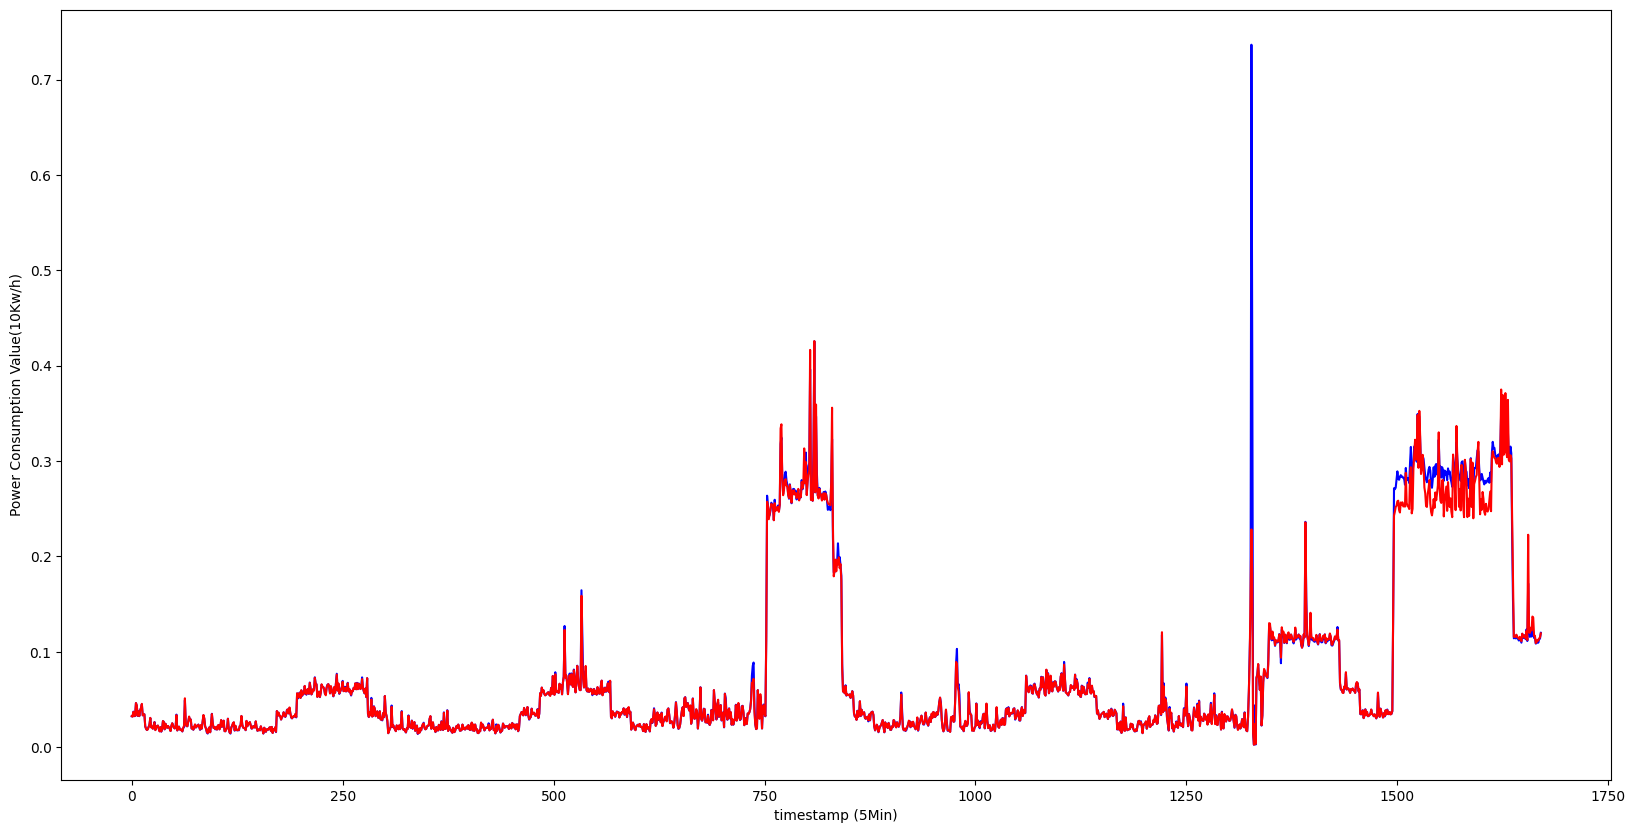

range(0, 1671) range(0, 1671)


In [24]:
a = range(len(y_pred))
b = range(len(y_test))
fig, ax = pyplot.subplots(figsize=(20,10))
ax.plot(b, y_test, 'b', label='Actual')
ax.plot(a, y_pred, 'r', label='Predicted')
ax.set_xlabel("timestamp (5Min)")
ax.set_ylabel("Power Consumption Value(10Kw/h)")

pyplot.show()
a = range(len(y_pred))
b = range(len(y_test))
print (a,b)

In [ ]:
accuracy = np.mean(y_pred == y_test)
print(f"Accuracy: {accuracy}")

Accuracy: 0.003590664272890485


In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score


# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, y_pred)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, y_pred)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, y_pred)
print('F1 score: %f' % f1)

ValueError: ignored

In [ ]:
# Predict total power usage for a new sample
new_sample = np.array(...)  # New input sample
predicted_power_usage = regressor.predict(new_sample[np.newaxis])
print(f"Predicted Power Usage: {predicted_power_usage}")
